# RossmannStoreSales

## Dataset Information

### train.csv
This is the main training dataset which contains data about the sales figures for a store on a
particular date.

#### Data Fields:
1. Store: a unique numerical store identifier (1 - 1,115)
2. DayOfWeek: the day of week (1 - 7)
3. Date: the date, ranging from 2013-01-01 to 2015-07-31
4. Sales: the turnover of the specified store on the specified date
5. Customers: the number of customers of the specified store on the specified date
6. Open: indicates whether the store was open (0 = Closed, 1 = Open)
7. Promo: indicates whether the store was running a promotion (0 = No, 1 = Yes)
8. StateHoliday: indicates if it was a state holiday (a = Public holiday, b = Easter holiday, c = Christmas, 0 = None)
9. SchoolHoliday: indicates if it was a school holiday (0 = No, 1 = Yes)

**Number of Records**: 1,017,209

### store.csv
This dataset contains supplementary information about each of the 1,115 stores and helps
identify unique features which may (or may not) affect sales.

#### Data Fields
1. Store: a unique numerical store identifier (1 - 1,115)
2. StoreType: differentiates between the 4 different types of stores (a, b, c, d)
3. Assortment: describes the assortment of goods carried by the store (a = Basic, b = Extra, c = Extended)
4. CompetitionDistance: the distance (in metres) to the nearest competitor’s store
5. CompetitionOpenSinceMonth: the month in which the competition opened
6. CompetitionOpenSinceYear: the year in which the competition opened
7. Promo2: indicates if a store is participating in a continuing and consecutive promotion (0 = No, 1 = Yes)
8. Promo2SinceWeek: the week of the year in which the store began participating in Promo2 (from 1 - 52, presumably, but some weeks are unrepresented in the data)
9. Promo2SinceYear: the year in which the store began participating in Promo2 (from 2009 - 2015)
10. PromoInterval: describes the consecutive intervals in which Promo2 is activated, giving the months the promotion is renewed (either “Jan,Apr,Jul,Oct”, “Feb,May,Aug,Nov” or “Mar,Jun,Sept,Dec”)

**Number of Records**: 1,115

### test.csv
This dataset is to be used for testing and evaluating the model.

#### Data Fields
Same as train.csv, with the exclusion of Customers & Sales (Sales to be predicted by the model) and an additional field Id which represents a (Store, Date) tuple that is used to label predictions for submission to Kaggle.

**Number of Records**: 41,088

In [11]:
# python imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
training_df = pd.read_csv("data/train.csv", dtype={"StateHoliday": pd.np.string_}, parse_dates=[2])
store_df = pd.read_csv("data/store.csv", dtype={"StateHoliday": pd.np.string_}, parse_dates=[3])

In [45]:
# general information of datasets
training_df.info()
training_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [28]:
# replace null elements with 1 if day of week is not 7
training_df['Open'].fillna(value=(training_df['DayOfWeek'] != 7).astype(int))
# sanity check
training_df[training_df['Open'].isnull()]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


Count of Zero Sales DF
Store            172871
DayOfWeek        172871
Date             172871
Sales            172871
Customers        172871
Open             172871
Promo            172871
StateHoliday     172871
SchoolHoliday    172871
dtype: int64
Count of Zero Sales DF where DayOfWeek is Sunday
Store            141137
DayOfWeek        141137
Date             141137
Sales            141137
Customers        141137
Open             141137
Promo            141137
StateHoliday     141137
SchoolHoliday    141137
dtype: int64
Count of Zero Sales DF where SchoolHoliday is 1
Store            18276
DayOfWeek        18276
Date             18276
Sales            18276
Customers        18276
Open             18276
Promo            18276
StateHoliday     18276
SchoolHoliday    18276
dtype: int64
Count of Zero Sales DF where StateHoliday is not 0
Store            30140
DayOfWeek        30140
Date             30140
Sales            30140
Customers        30140
Open             30140
Promo        

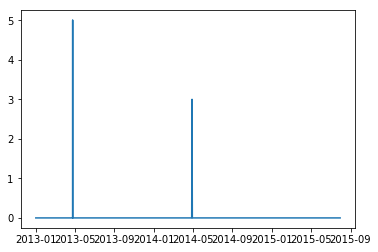

In [64]:
# analysis on training dataset when the sales is zero (extreme case)
zero_sales_df = training_df[training_df['Sales'] == 0]
print('Count of Zero Sales DF')
print(zero_sales_df.count())
print('Count of Zero Sales DF where DayOfWeek is Sunday')
print(zero_sales_df[zero_sales_df['DayOfWeek'] == 7].count())
print('Count of Zero Sales DF where SchoolHoliday is 1')
print(zero_sales_df[zero_sales_df['SchoolHoliday'] == 1].count())
print('Count of Zero Sales DF where StateHoliday is not 0')
print(zero_sales_df[zero_sales_df['StateHoliday'] != '0'].count())
print('Count of Zero Sales DF where Promo is 0')
print(zero_sales_df[zero_sales_df['Promo'] == 0].count())
print('Zero sales count - zero customers count')
print(zero_sales_df.count() - training_df[training_df['Customers'] == 0].count())
plt.plot(zero_sales_df.sort_values('Date')['Date'], zero_sales_df.sort_values('Date')['Customers'])

In [65]:
training_df.groupby([training_df['Store']]).describe()

Customers                                                              \
          count         mean          std     min      25%     50%      75%   
Store                                                                         
1         942.0   467.646497   228.930850     0.0   463.00   529.0   598.75   
2         942.0   486.045648   260.284503     0.0   348.00   542.0   667.75   
3         942.0   620.286624   323.366048     0.0   475.00   705.0   834.75   
4         942.0  1100.057325   526.186981     0.0  1094.50  1261.5  1397.75   
5         942.0   444.360934   253.050581     0.0   231.00   537.0   621.00   
6         942.0   525.990446   280.428208     0.0   396.75   594.0   727.00   
7         942.0   791.474522   402.859401     0.0   669.25   893.0  1059.00   
8         942.0   547.799363   293.404732     0.0   374.25   630.5   759.75   
9         942.0   479.487261   238.656876     0.0   460.50   539.0   620.75   
10        942.0   494.332272   234.069712     0.0   493.25   567.0   622.75   
11        942.0   940.543524   470.841117     0.0   864.50  1074.0  1213.00   
12        942.0   746.508493   361.541771     0.0   739.00   835.0   952.00   
13        758.0   313.641161   167.602980     0.0   276.00   345.5   421.00   
14        942.0   522.200637   268.052815     0.0   411.25   616.0   692.75   
15        942.0   552.130573   265.399378     0.0   550.25   625.0   698.50   
16        942.0   703.158174   359.634984     0.0   557.50   840.0   936.00   
17        942.0   657.208068   368.943638     0.0   370.25   759.0   906.50   
18        942.0   592.128450   296.954437     0.0   510.25   681.0   782.75   
19        942.0   516.579618   267.539979     0.0   401.00   606.0   694.00   
20        758.0   692.952507   370.871672     0.0   507.00   838.5   967.75   
21        942.0   425.916136   219.367510     0.0   378.00   485.0   566.00   
22        758.0   411.779683   210.933298     0.0   373.25   478.0   547.50   
23        942.0   398.957537   203.606642     0.0   371.00   439.0   517.00   
24        942.0   690.870488   348.512994     0.0   662.25   764.5   896.00   
25        942.0  1250.288747   686.376385     0.0  1182.00  1456.5  1692.00   
26        942.0   461.623142   235.650557     0.0   416.75   512.0   598.00   
27        942.0   888.786624   451.824284     0.0   841.00   973.5  1162.75   
28        942.0   475.791932   280.422505     0.0   292.00   551.0   657.00   
29        942.0   540.587049   277.347395     0.0   498.50   598.0   703.00   
30        942.0   641.006369   336.919142     0.0   552.50   713.0   861.75   
...         ...          ...          ...     ...      ...     ...      ...   
1086      942.0   695.715499   383.239685     0.0   557.25   741.0   954.50   
1087      942.0   512.247346   244.784829     0.0   507.25   586.0   650.75   
1088      942.0   401.199575   212.137426     0.0   303.25   468.0   541.00   
1089      942.0   829.093418   409.280837     0.0   820.00   943.5  1064.75   
1090      942.0   650.546709   367.740034     0.0   338.50   775.0   898.75   
1091      942.0   580.252654   285.283776     0.0   560.00   646.5   739.75   
1092      758.0   955.994723   462.448603     0.0  1004.25  1124.0  1225.00   
1093      942.0   719.926752   357.054763     0.0   701.25   827.0   920.50   
1094      758.0   306.767810   156.217040     0.0   294.00   345.0   407.75   
1095      942.0   562.701699   285.704750     0.0   498.00   645.5   733.00   
1096      942.0   523.520170   262.661978     0.0   503.25   582.0   676.75   
1097      942.0  2420.921444   329.306198  1055.0  2245.75  2460.0  2619.00   
1098      942.0   587.133758   317.260586     0.0   375.25   697.5   794.00   
1099      942.0   928.975584   302.441743     0.0   813.00   955.5  1098.00   
1100      942.0   546.181529   301.256021     0.0   426.25   614.0   746.00   
1101      942.0   822.659236   397.171891     0.0   818.00   921.5  1038.75   
1102      758.0   579.721636   284.903080     0.0   592.